# SpectralFPM Simulation

Neerja Aggarwal

Oct 23rd, 2024

Simulate the measurement & attempt reconstruction for a spectral object. 


In [1]:
import fpm_helper as fpm
import matplotlib.pyplot as plt
import numpy as np
import torch
# plt.style.use('dark_background')

In [2]:
device = fpm.use_gpu(0)

cuda:0


# setup the fpm system

In [3]:
mag = 4 # 4x 
pix_size_camera = 4 #  micron"

wv_start = 400e-3 # micron
wv_end = 800e-3 # micron
wv_step = 100e-3 # micron
wv_range = np.arange(wv_start,wv_end, wv_step)
print(wv_range)

# wv = 500e-3 # micron
na_obj = 0.05 # low na objective 

fpm_setup = fpm.FPM_setup(mag = mag, pix_size_camera = pix_size_camera, wv = wv_range, na_obj = na_obj)
print(fpm_setup)

[0.4 0.5 0.6 0.7]
Using stock object data
FPM Setup Parameters:
--------------------
Camera pixel size: 4 microns
Magnification: 4x
Object pixel size: 1.000 microns
Numerical aperture: 0.05
Wavelength(s): [0.4 0.5 0.6 0.7] microns
Number of wavelengths: 4
Image dimensions: 1178 x 1178 pixels
LED Spacing: 5 mm
Distance: 75 mm
Total number of angles: 0
--------------------


/home/neerja/CODE/SpectralPtychographyProjectGitRepo/fpm_helper.py:182: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1729496767994/work/torch/csrc/utils/tensor_numpy.cpp:204.)
  im = torch.from_numpy(image.imread(path))[:, :, 0]  # Use first channel
/home/neerja/CODE/SpectralPtychographyProjectGitRepo/fpm_helper.py:297: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /opt/conda/conda-bld/pytorch_1729496767994/work/aten/src/ATen/native/Copy.cpp:308.)
  pupilstack[k, :, :] = self.createPupilStop(wv)


# view the obj

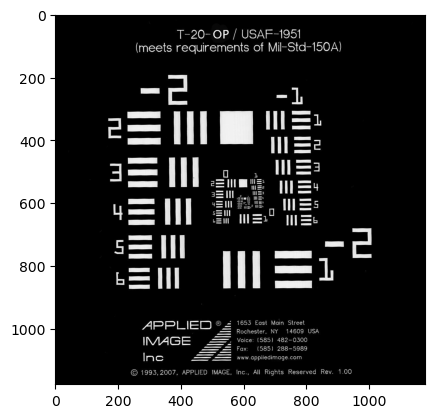

In [4]:
plt.imshow(torch.sum(fpm_setup.objstack, dim =0), cmap = 'gray')

/home/neerja/CODE/SpectralPtychographyProjectGitRepo/fpm_helper.py:664: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  f_width_ind = int(torch.floor(torch.tensor(f_width/df)))  # Convert to PyTorch operation


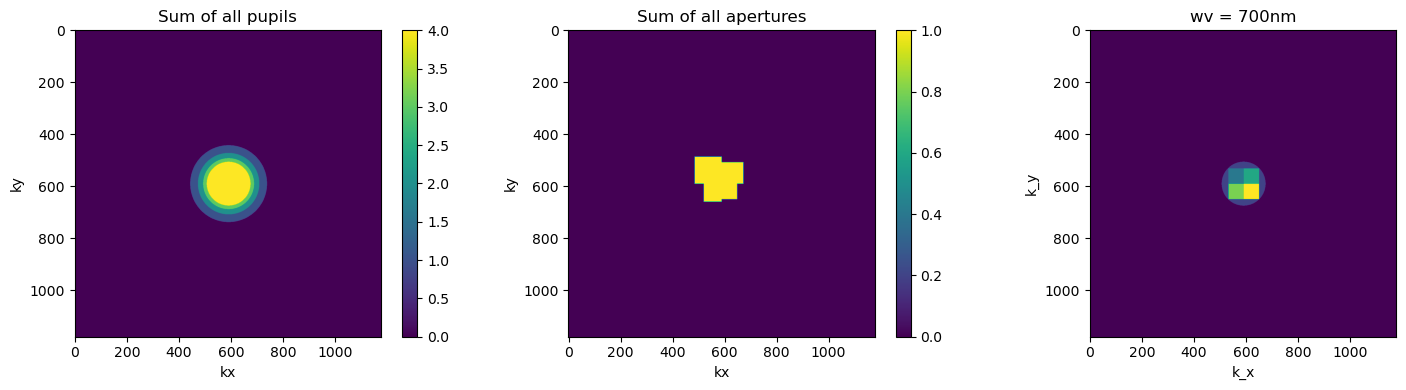

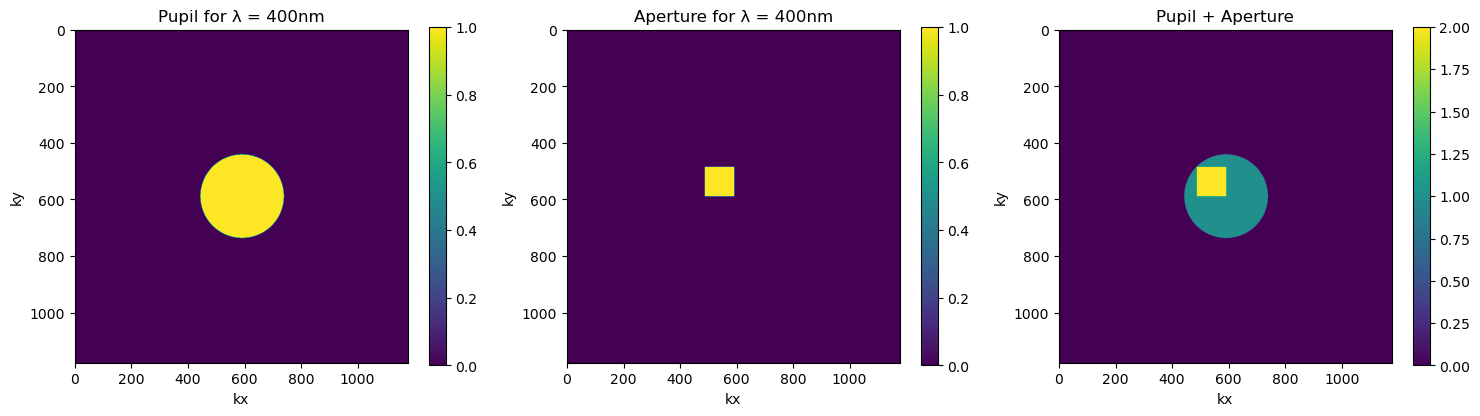

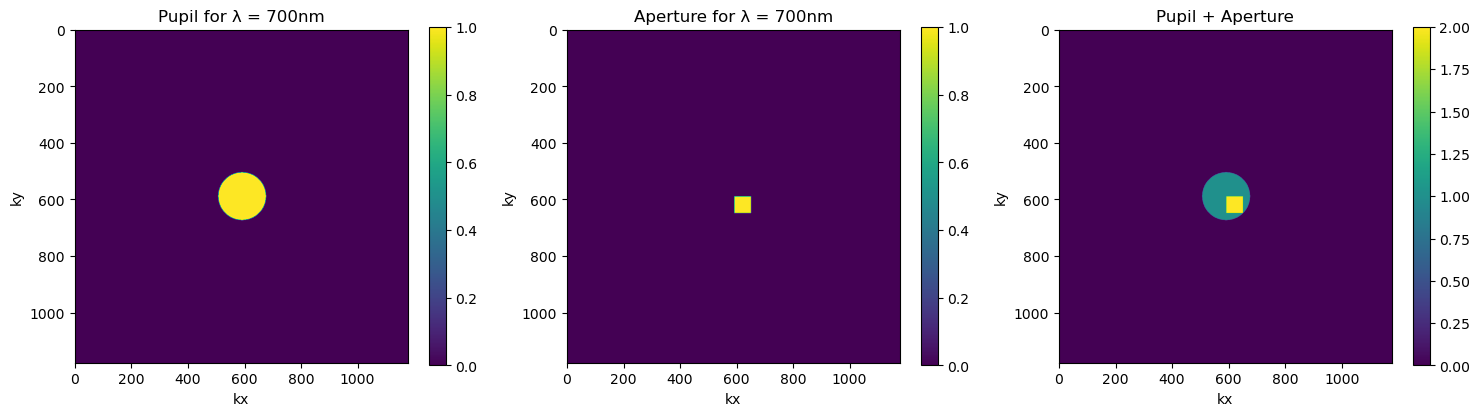

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 

In [5]:
# Create default tiled aperture

# Or create custom tile pattern first
tile = fpm_setup.createTile()
# Modify tile pattern if desired...
aperture_stack = fpm_setup.createAperture(tile)
# update the pupil stack with the aperture

# View all wavelengths combined
fpm_setup.visualize_pupil_aperture()

# View specific wavelength
fpm_setup.visualize_pupil_aperture(wavelength_index=0)
fpm_setup.visualize_pupil_aperture(wavelength_index=3)

# update the pupil stack with the aperture
fpm_setup.updatePupilWithAperture()


# simulate some measurements

[((0.0, 0.0), (0, 1, 2, 3)), ((0.0016706903825780305, 0.0011357832296199242), (0, 1, 2, 3)), ((0.0015509982470452413, 0.0037308358616878756), (0, 1, 2, 3)), ((-0.0010219495468093297, 0.005973752189464133), (0, 1, 2, 3)), ((-0.005312562631912008, 0.006088898923513479), (0, 1, 2, 3)), ((-0.009587877001153683, 0.0031776276755214154), (0, 1, 2, 3)), ((-0.01188026482120454, -0.0024020381650145424), (0, 1, 2, 3)), ((-0.01076209950038452, -0.009172957218175699), (0, 1, 2, 3)), ((-0.005860776939766137, -0.015060346716835045), (0, 1, 2, 3)), ((0.002011365769094091, -0.018068255159939088), (0, 1, 2, 3)), ((0.011095430443262397, -0.01688042652644667), (0, 1, 2, 3)), ((0.019176261890718138, -0.011224855791136306), (0, 1, 2, 3)), ((0.02416001982791531, -0.0019394195646933348), (0, 1, 2, 3)), ((0.024578860044749493, 0.009238881357962095), (0, 1, 2, 3)), ((0.019911827716951016, 0.020080444543502735), (0, 1, 2, 3)), ((0.010677765546115492, 0.028351708150290107), (0, 1, 2, 3)), ((-0.00168886453803549, 

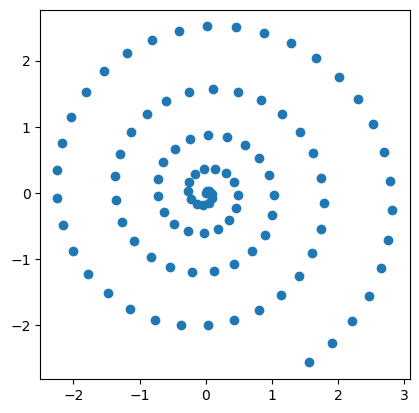

In [10]:
d = 75
led_spacing = 5
num_leds = 100
# list_leds = fpm.createlist_led(num_leds,-3,3)
list_leds = fpm.create_spiral_leds(num_leds, -3, 3, alpha = 20)
# print(list_leds)
plt.scatter(list_leds[:,1],list_leds[:,0])
plt.axis('square')
list_illums = fpm_setup.createUniformWavelengthPerAngleIllumList(list_leds)
print(list_illums)


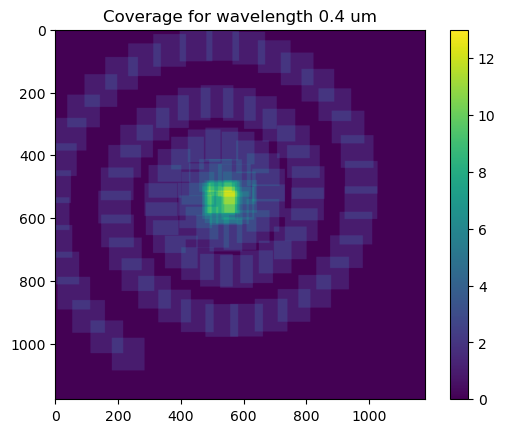

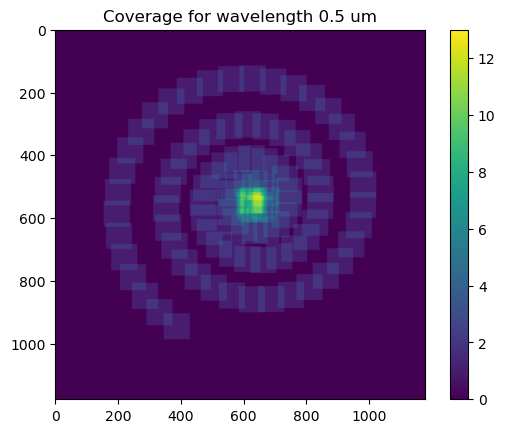

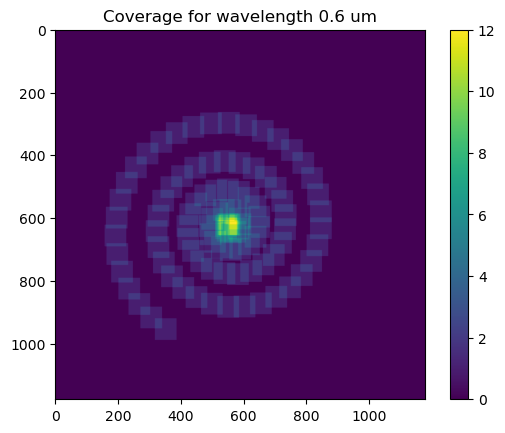

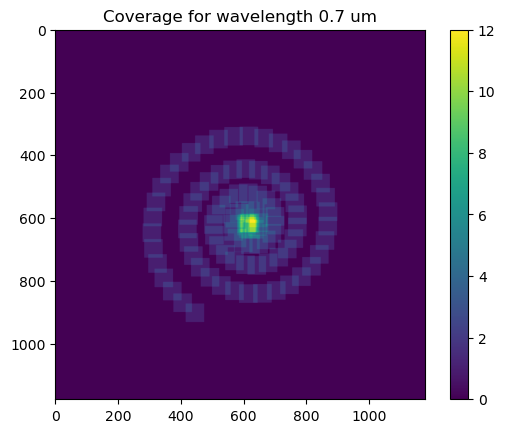

In [11]:
# look at the coverage
coverage = fpm_setup.visualize_objectfft_coverage(list_illums)
for wvind in range(fpm_setup.Nw):
    plt.figure()
    plt.imshow(coverage[wvind].cpu())
    plt.colorbar()
    plt.title('Coverage for wavelength {} um'.format(wv_range[wvind]))
    plt.show()


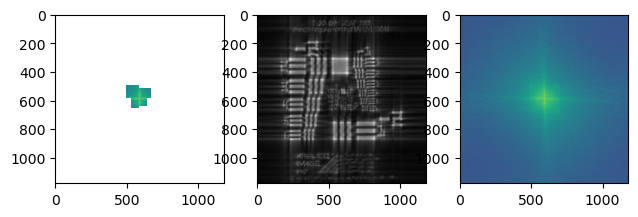

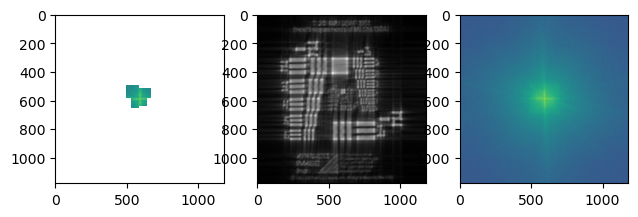

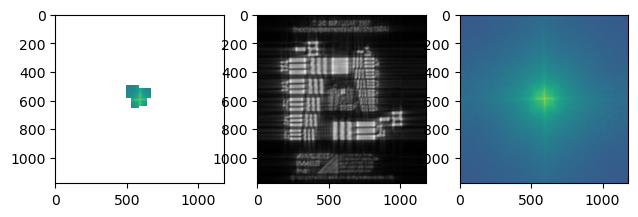

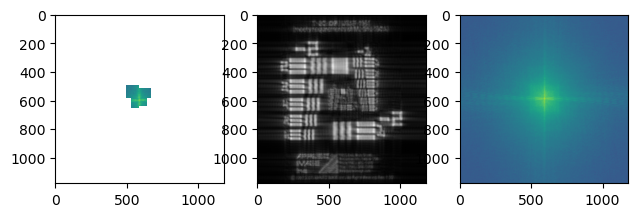

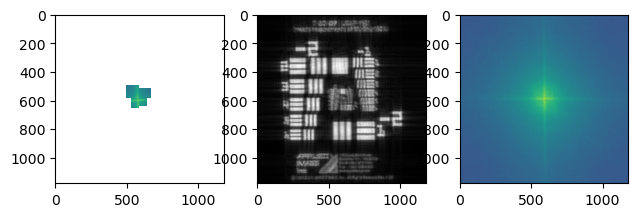

In [12]:
fpm_setup.to(device)
measstack = fpm_setup.createMeasStackFromListIllums()

# Recon

In [13]:
recon = fpm.Reconstruction(fpm_setup, measstack, device = 2)
recon.initRecon()
recon.parameters(step_size=1e-3, num_iters=100)
print(recon)

cuda:2
Reconstruction Parameters:
--------------------
Number of measurements: 100
Device: cuda:2
Step size: 0.001
Iterations per measurement: 100
Number of epochs: 1
Optimizer type: Adam
Loss function: 2-norm
--------------------
FPM Setup Parameters:
--------------------
Camera pixel size: 4 microns
Magnification: 4x
Object pixel size: 1.000 microns
Numerical aperture: 0.05
Wavelength(s): [0.4 0.5 0.6 0.7] microns
Number of wavelengths: 4
Image dimensions: 1178 x 1178 pixels
LED Spacing: 5 mm
Distance: 75 mm
Total number of angles: 100
Number of illumination configurations: 100
Illumination strategy: Uniform (all wavelengths per angle)
--------------------


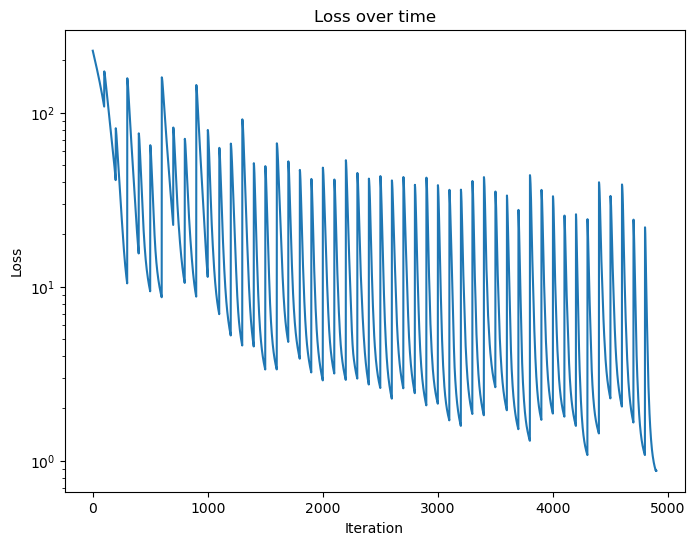

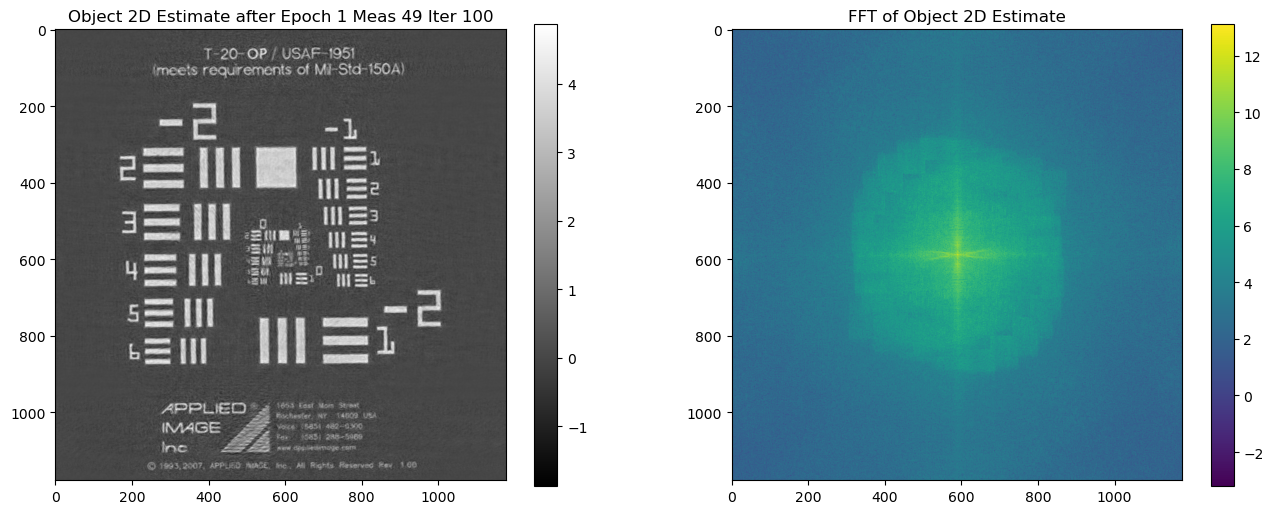

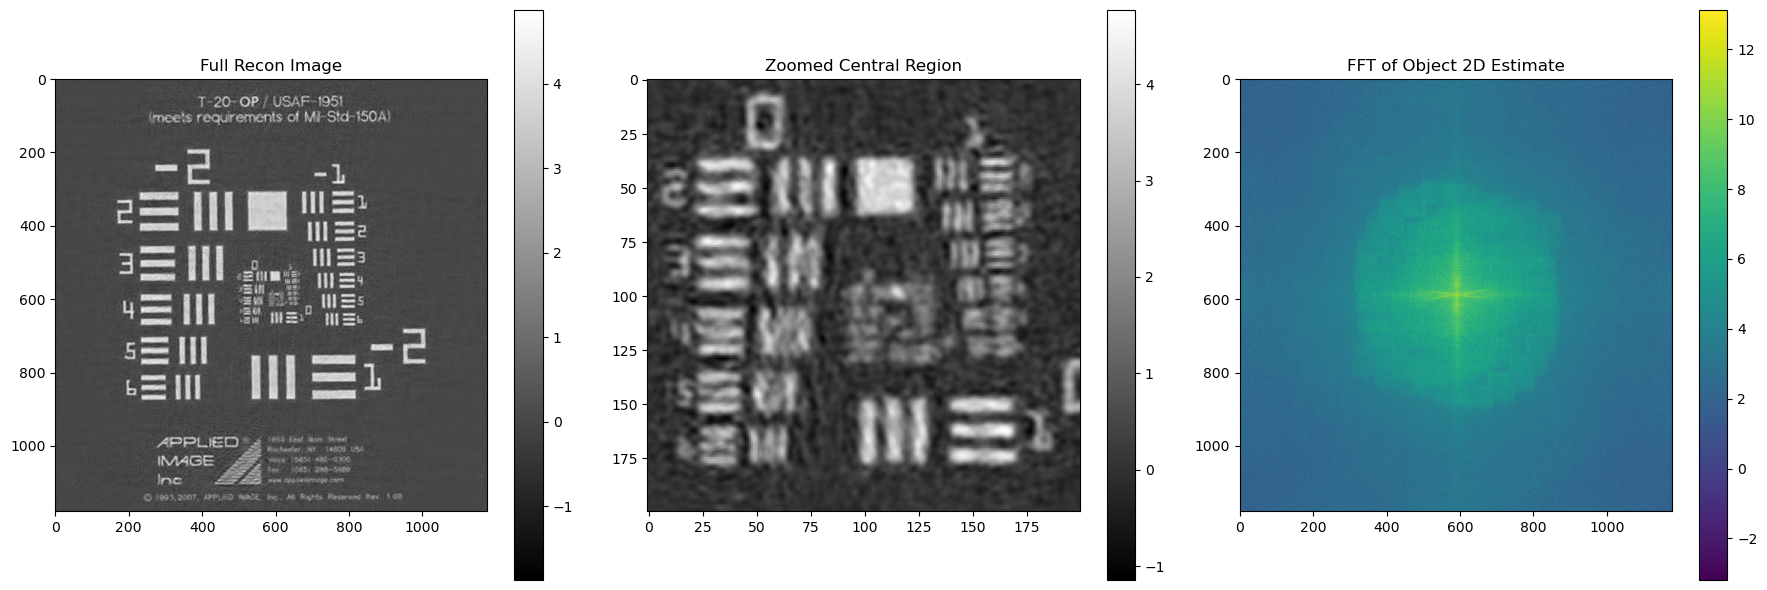

In [14]:
recon.train()

In [9]:
objest = recon.objest.detach().cpu().numpy()

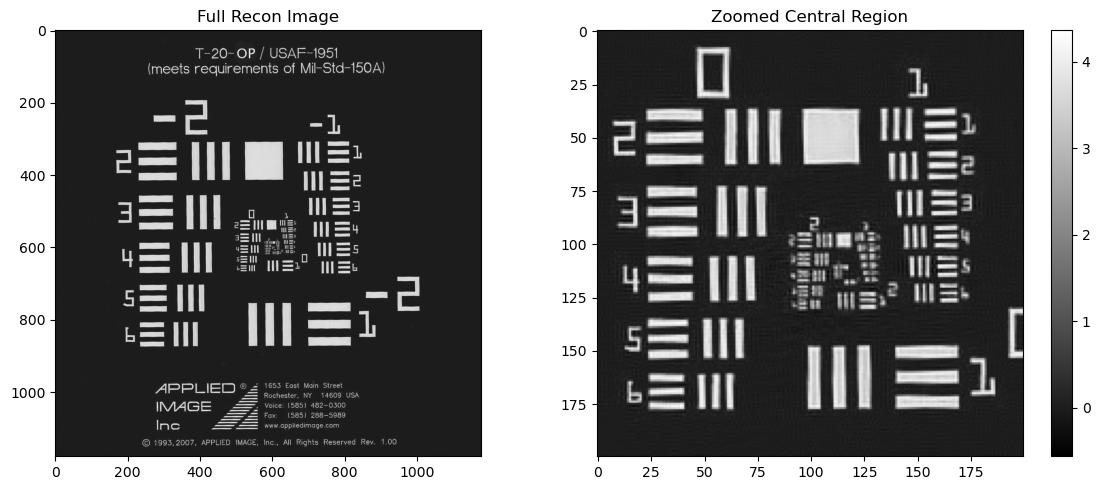

In [10]:
# zooom into the center smaller region
# Get the object estimate
obj2d = np.sum(objest, axis=0)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Full image
ax1.imshow(obj2d, cmap='gray')
ax1.set_title('Full Recon Image')

# Zoomed central region
center_y, center_x = obj2d.shape[0]//2, obj2d.shape[1]//2
zoom_size = 200  # Adjust this value to change zoom level
zoom_region = obj2d[center_y-zoom_size//2:center_y+zoom_size//2, 
                   center_x-zoom_size//2:center_x+zoom_size//2]
im2 = ax2.imshow(zoom_region, cmap='gray')
ax2.set_title('Zoomed Central Region')
fig.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

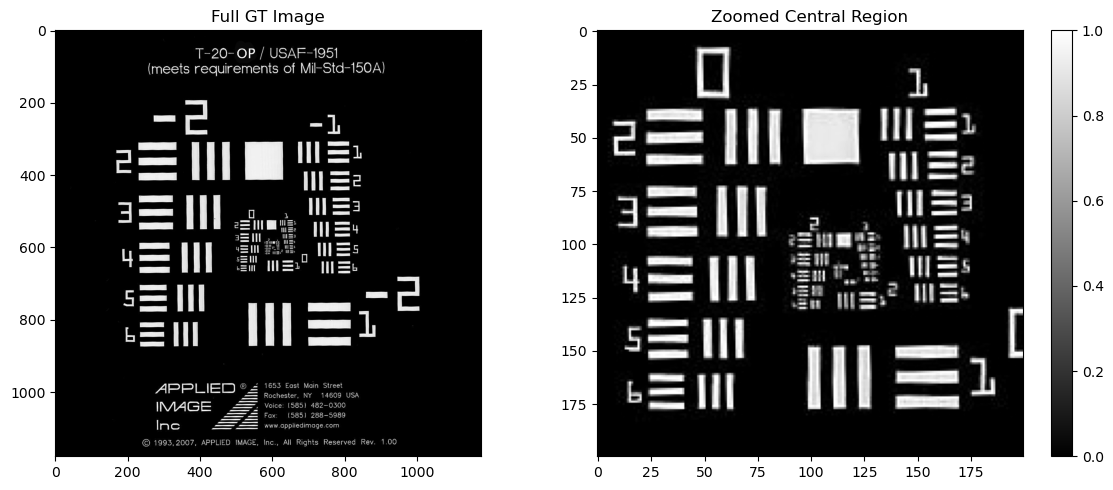

In [11]:
# look a the ground truth
plt.figure()
obj2d = np.squeeze(fpm_setup.obj.detach().cpu().numpy())

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Full image
ax1.imshow(obj2d, cmap='gray')
ax1.set_title('Full GT Image')

# Zoomed central region
center_y, center_x = obj2d.shape[0]//2, obj2d.shape[1]//2
zoom_size = 200  # Adjust this value to change zoom level
zoom_region = obj2d[center_y-zoom_size//2:center_y+zoom_size//2, 
                   center_x-zoom_size//2:center_x+zoom_size//2]
im2 = ax2.imshow(zoom_region, cmap='gray')
ax2.set_title('Zoomed Central Region')
fig.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Recon FFT')

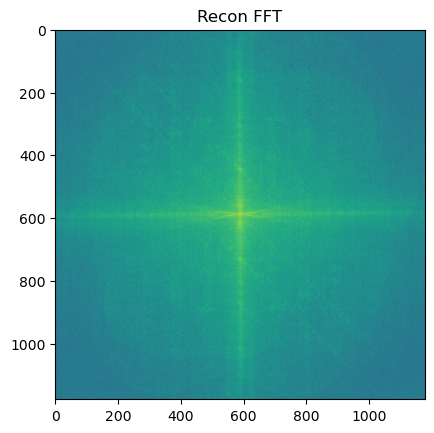

In [12]:
plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(np.squeeze(np.sum(objest, axis = 0)))))))
plt.title('Recon FFT')

Text(0.5, 1.0, 'GT FFT')

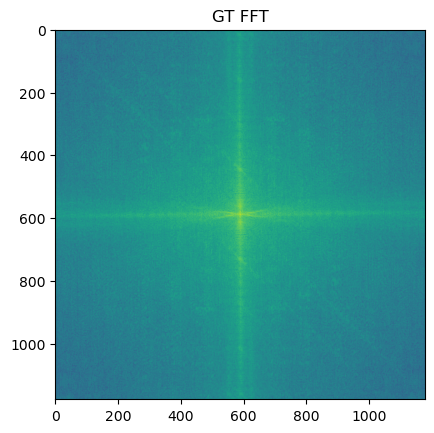

In [13]:
plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(np.squeeze(recon.fpm_setup.obj.cpu().numpy()))))))
plt.title('GT FFT')

## compare wavelength channels

Text(0.5, 1.0, '800 nm')

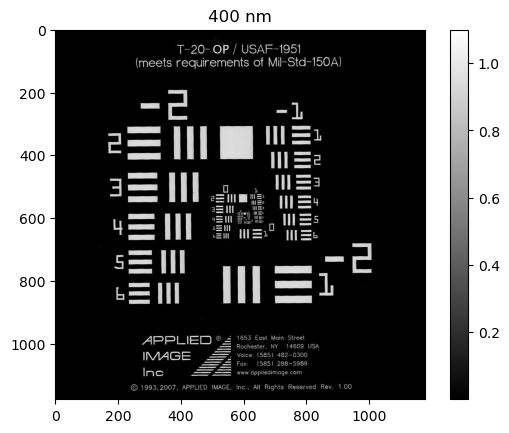

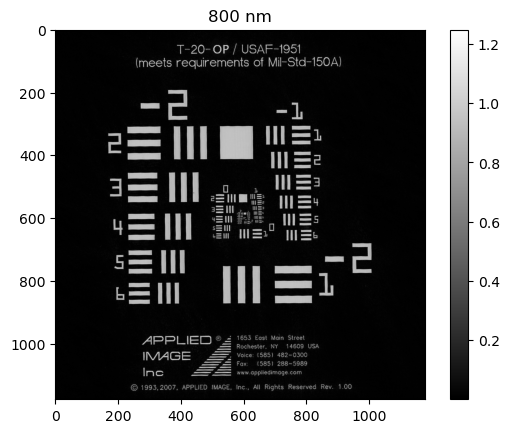

In [14]:
plt.imshow(np.abs(objest[0,:,:]), cmap = 'gray')
plt.colorbar()
plt.title('400 nm')
plt.figure()
plt.imshow(np.abs(objest[-1,:,:]), cmap = 'gray')
plt.colorbar()
plt.title('800 nm')
